In [19]:
!pip install rdkit

#Section 1. - Importing and preprocessing the training data

In [20]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

# Loading the dataset
url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
df = pd.read_csv(url)

# Converting SMILES to RDKit Mol objects
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

# Calculating RDKit descriptors
def calculate_descriptors(mol):
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol)
    }
    return pd.Series(descriptors)

df = df.join(df['mol'].apply(calculate_descriptors))

# Dropping rows with missing values (where molecules couldn't be processed)
df = df.dropna()

# Defining features (X) and target (y)
X = df[['MolWt', 'NumHDonors', 'NumHAcceptors', 'Number of Rings', 'Number of Rotatable Bonds']]
y = df['measured log solubility in mols per litre']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X

,MolWt,NumHDonors,NumHAcceptors,Number of Rings,Number of Rotatable Bonds
0,457.432,7.0,12.0,3,7
1,201.225,1.0,2.0,2,2
2,152.237,0.0,1.0,0,4
3,278.354,0.0,0.0,5,0
4,84.143,0.0,1.0,1,0
...,...,...,...,...,...
1123,197.381,0.0,0.0,0,0
1124,219.266,1.0,5.0,0,1
1125,246.359,0.0,5.0,0,7
1126,72.151,0.0,0.0,0,1


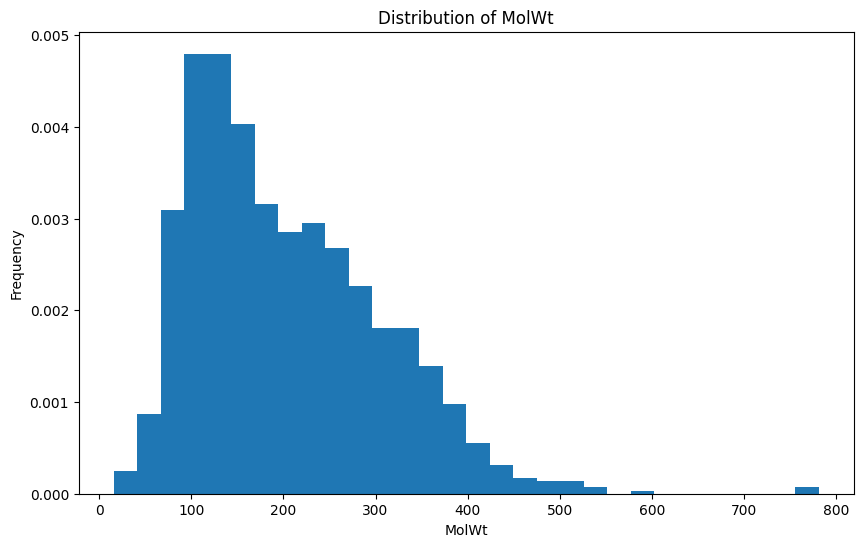

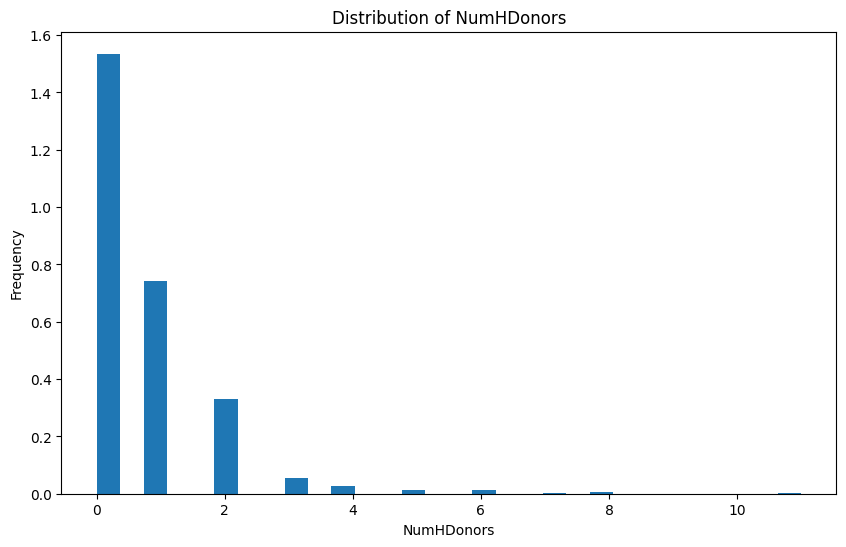

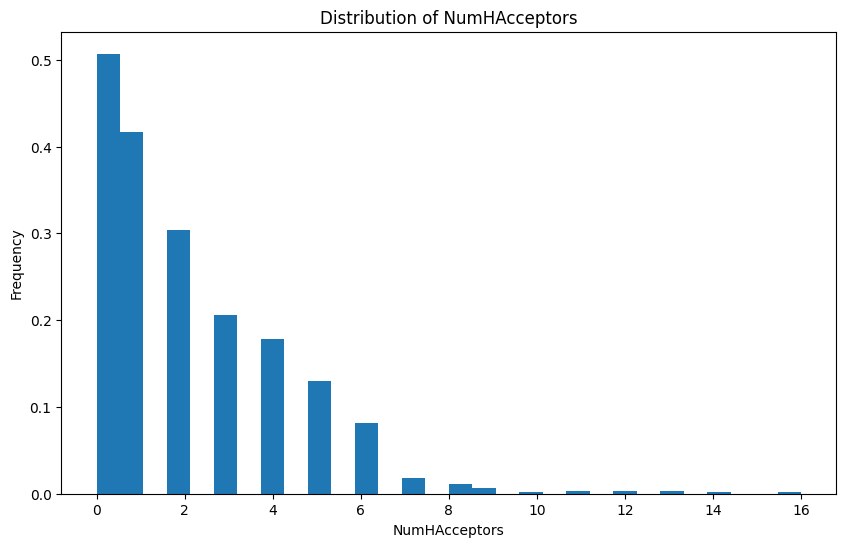

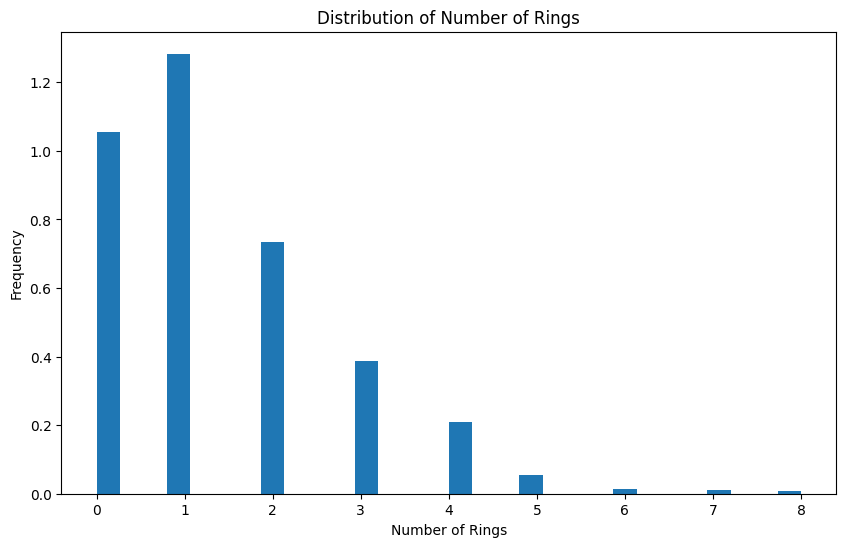

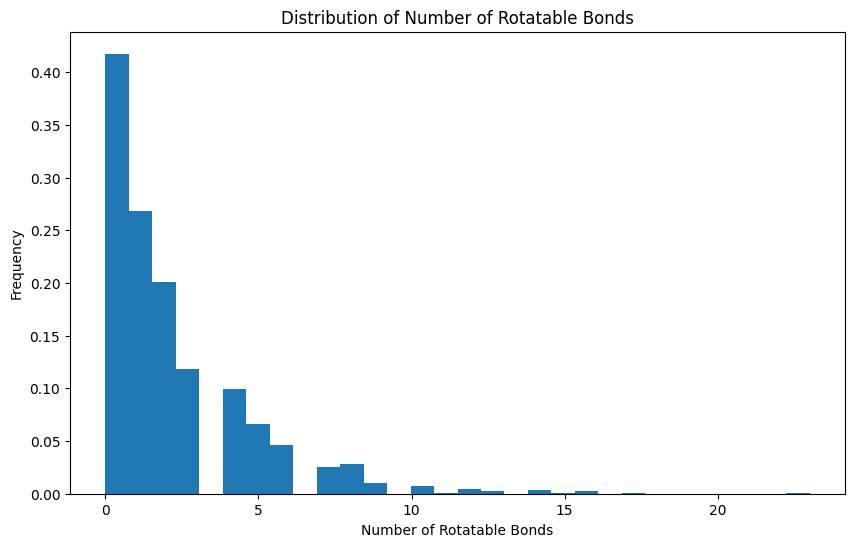

In [22]:
import matplotlib.pyplot as plt

descriptors = ['MolWt', 'NumHDonors', 'NumHAcceptors', 'Number of Rings', 'Number of Rotatable Bonds']

for descriptor in descriptors:
  plt.figure(figsize=(10, 6))
  plt.title(f'Distribution of {descriptor}')
  plt.xlabel(descriptor)
  plt.ylabel('Frequency')
  plt.hist(df[[descriptor]], density=True, bins=30)

#Section 2 - Generating test data from SMILES

In [23]:
from sklearn.preprocessing import StandardScaler
from rdkit.Chem import rdMolDescriptors

# Calculating descriptors for molecules in SMILE format
def calculate_descriptors(mol):
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'Number of Rings': rdMolDescriptors.CalcNumRings(mol),
        'Number of Rotatable Bonds': rdMolDescriptors.CalcNumRotatableBonds(mol)
    }
    return pd.Series(descriptors)

# Normalizng the data via StandardScaler
def normalize_data(dataframe):
    scaler = StandardScaler()
    normalized = scaler.fit_transform(dataframe)

    return dataframe

SECTION XX: Testing the ML model on data generated by using rdkit


In [24]:
smilesList = [
    'C', 'CC', 'CCC', 'CCCC', 'CCCCC', 'CCCCCC',
    'CCCCCCC', 'CCN', 'CC(=O)O', 'CCOCC', 'CC(=O)CC',
    'CC(=O)OCC', 'CCCCO', 'C(C(=O)O)C(N)C', 'CCCCCO'
]

# The solubities in a form of log([mol of substance]/[litre of H2O]). Experimental measurements based on the literature.
log_solubilities = [-2.82, -2.70,	-2.82,	-2.98,	-2.65,	-3.96,	-4.53,	-1.57,	1.00,	-0.12,	0.44,	-0.10,	-0.01,	0.79,	-0.61]
# For refernece - "Yalkowsky, S.H., He, Yan, Jain, P. Handbook of Aqueous Solubility Data Second Edition. CRC Press, Boca Raton, FL 2010"


In [25]:
# Creat a SMILES dataframe
smilesDF = pd.DataFrame(smilesList, columns=['smiles'])

# Convert SMILES to RDKit Mol objects
smilesDF['mol'] = smilesDF['smiles'].apply(Chem.MolFromSmiles)

# Calculate the descriptors in a seperate dataframe
descriptors_df = smilesDF['mol'].apply(calculate_descriptors)

# Merge the descripotrs and mol dataframe
testDFfromSMILES = pd.concat([smilesDF.drop(columns=['mol', 'smiles']), descriptors_df], axis=1)

In [26]:
testDFfromSMILES

,MolWt,NumHDonors,NumHAcceptors,Number of Rings,Number of Rotatable Bonds
0,16.043,0.0,0.0,0.0,0.0
1,30.070,0.0,0.0,0.0,0.0
2,44.097,0.0,0.0,0.0,0.0
3,58.124,0.0,0.0,0.0,1.0
4,72.151,0.0,0.0,0.0,2.0
5,86.178,0.0,0.0,0.0,3.0
6,100.205,0.0,0.0,0.0,4.0
7,45.085,1.0,1.0,0.0,0.0
8,60.052,1.0,1.0,0.0,0.0
9,74.123,0.0,1.0,0.0,2.0


#Section 3 - Feeding ML algorithms with data

##Section 3.1 - Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_smiles_scaled = scaler.transform(testDFfromSMILES)

linear = LinearRegression()
linear.fit(X_train_scaled, y_train)

# Making predictions
y_pred = linear.predict(X_test_scaled)
y_pred_smiles = linear.predict(X_smiles_scaled)

# Evaluating the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2_smiles = r2_score(log_solubilities, y_pred_smiles)

print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'R² Score for SMILES: {r2_smiles}')

RMSE: 1.4175347580906559
R² Score: 0.7001071101763268
R² Score for SMILES: 0.29067202364757283


##Section 3.2 - Decision Tree Classifier

In [28]:
from sklearn.tree import DecisionTreeRegressor

results_tree = {}

for criterion in ['squared_error', 'absolute_error']:
  for max_depth in [None, 10, 100]:
    tree = DecisionTreeRegressor(criterion=criterion, max_depth=max_depth)
    tree.fit(X_train, y_train)

    #Making predictions
    y_pred = tree.predict(X_test)
    y_pred_smiles = tree.predict(testDFfromSMILES)

    #Evaluating the models performance
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_smiles = r2_score(log_solubilities, y_pred_smiles)

    #Saving results
    results_tree[(criterion, max_depth)] = {'rmse': rmse, 'r2': r2, 'r2_smiles': r2_smiles}

    print(f'Decision tree regressor with hyperparameters criterion = {criterion} and max_depth = {max_depth}')
    print(f'RMSE: {rmse}')
    print(f'R² Score: {r2}')
    print(f'R² Score for SMILES: {r2_smiles}')

#Finding the best model, based on r2
best_model_tree = max(results_tree, key=lambda k: results_tree[k]['r2'])
best_r2 = results_tree[best_model_tree]['r2']
print(f"#\nBest model: {best_model_tree}, R² score: {best_r2}")

#Finding the best model, based on r2_smiles
best_model_smiles = max(results_tree, key=lambda k: results_tree[k]['r2_smiles'])
best_r2_smiles = results_tree[best_model_smiles]['r2_smiles']
print(f"#\nBest model [foreign data]: {best_model_smiles}, R² score: {best_r2_smiles}")

Decision tree regressor with hyperparameters criterion = squared_error and max_depth = None
RMSE: 1.3206324097366455
R² Score: 0.7206077187947195
R² Score for SMILES: 0.6357869311740253
Decision tree regressor with hyperparameters criterion = squared_error and max_depth = 10
RMSE: 1.3076587040210637
R² Score: 0.7233524289872288
R² Score for SMILES: 0.6301374474511112
Decision tree regressor with hyperparameters criterion = squared_error and max_depth = 100
RMSE: 1.3477178245596542
R² Score: 0.714877543025142
R² Score for SMILES: 0.6357869311740253
Decision tree regressor with hyperparameters criterion = absolute_error and max_depth = None
RMSE: 1.4113681880530975
R² Score: 0.7014117064116632
R² Score for SMILES: 0.6658931012772997
Decision tree regressor with hyperparameters criterion = absolute_error and max_depth = 10
RMSE: 1.2252729911504425
R² Score: 0.7407819060225806
R² Score for SMILES: 0.6606598557401937
Decision tree regressor with hyperparameters criterion = absolute_error an

##Section 3.3 - Random Forest Regression

In [29]:
from sklearn.ensemble import RandomForestRegressor

results_rf = {}

for n_estimators in [10, 100, 1000]:
  for max_depth in [None, 10, 100]:
    forest = RandomForestRegressor(n_estimators=n_estimators, criterion='squared_error', max_depth=None)
    forest.fit(X_train, y_train)

    # Making predictions
    y_pred = forest.predict(X_test)
    y_pred_smiles = forest.predict(testDFfromSMILES)

    # Evaluating the model
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_smiles = r2_score(log_solubilities, y_pred_smiles)

    #Saving results
    results_rf[(n_estimators, max_depth)] = {'rmse': rmse, 'r2': r2, 'r2_smiles': r2_smiles}

    print('################')
    print(f'Random forest regressor with hyperparameters n_estimators = {n_estimators} and max_depth = {max_depth}')
    print(f'RMSE: {rmse}')
    print(f'R² Score: {r2}')
    print(f'R² Score for SMILES: {r2_smiles}')

best_model_rf = max(results_rf, key=lambda k: results_rf[k]['r2'])
best_r2 = results_rf[best_model_rf]['r2']
print(f"#\nBest model: {best_model_rf}, R² score: {best_r2}")

best_model_smiles = max(results_rf, key=lambda k: results_rf[k]['r2_smiles'])
best_r2_smiles = results_rf[best_model_smiles]['r2_smiles']
print(f"#\nBest model [foreign data]: {best_model_smiles}, R² score: {best_r2_smiles}")

################
Random forest regressor with hyperparameters n_estimators = 10 and max_depth = None
RMSE: 0.9487320013758714
R² Score: 0.7992867688521177
R² Score for SMILES: 0.5953645737310758
################
Random forest regressor with hyperparameters n_estimators = 10 and max_depth = 10
RMSE: 0.9243676173107702
R² Score: 0.804441284820318
R² Score for SMILES: 0.5816235427528565
################
Random forest regressor with hyperparameters n_estimators = 10 and max_depth = 100
RMSE: 0.9131829377396838
R² Score: 0.8068075096054109
R² Score for SMILES: 0.5838264039598144
################
Random forest regressor with hyperparameters n_estimators = 100 and max_depth = None
RMSE: 0.861172221394084
R² Score: 0.8178108687383401
R² Score for SMILES: 0.578046672447071
################
Random forest regressor with hyperparameters n_estimators = 100 and max_depth = 10
RMSE: 0.8866589467332568
R² Score: 0.8124189108547804
R² Score for SMILES: 0.5542612301722927
################
Random forest 

##Section 3.4 - Support Vector Machine

In [30]:
from sklearn.svm import SVR

results_svr = {}

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_smiles_scaled = scaler.transform(testDFfromSMILES)

for kernel in ['linear', 'rbf', 'poly']:
  for C in [0.1, 1, 10]:
    # Define the SVR model with RBF kernel
    svr = SVR(kernel=kernel, C=C, epsilon=0.1)

    # Train the model
    svr.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = svr.predict(X_test_scaled)
    y_pred_smiles = svr.predict(X_smiles_scaled)

    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_smiles = r2_score(log_solubilities, y_pred_smiles)

    #Saving results
    results_svr[(kernel, C)] = {'rmse': rmse, 'r2': r2, 'r2_smiles': r2_smiles}

    print(f'RMSE: {rmse}')
    print(f'R² Score: {r2}')
    print(f'R² Score for SMILES: {r2_smiles}')

best_model_svr = max(results_svr, key=lambda k: results_svr[k]['r2'])
best_r2 = results_svr[best_model_svr]['r2']
print(f"#\nBest model: {best_model_svr}, R² score: {best_r2}")

best_model_smiles = max(results_svr, key=lambda k: results_svr[k]['r2_smiles'])
best_r2_smiles = results_svr[best_model_smiles]['r2_smiles']
print(f"#\nBest model [foreign data]: {best_model_smiles}, R² score: {best_r2_smiles}")

RMSE: 1.4205993508731773
R² Score: 0.6994587665780923
R² Score for SMILES: 0.2737517401447386
RMSE: 1.4353633280464704
R² Score: 0.6963353075203733
R² Score for SMILES: 0.2665989252559371
RMSE: 1.433492779361864
R² Score: 0.6967310397924611
R² Score for SMILES: 0.2653107954463084
RMSE: 1.551204995395032
R² Score: 0.6718279067777306
R² Score for SMILES: 0.45406799243742846
RMSE: 0.9725489809152295
R² Score: 0.7942480614905078
R² Score for SMILES: 0.5371329899445554
RMSE: 0.9091105884986899
R² Score: 0.8076690536171415
R² Score for SMILES: 0.5624639263205968
RMSE: 5.215698326984251
R² Score: -0.10343032846307953
R² Score for SMILES: 0.07283842776396676
RMSE: 5.810834894840703
R² Score: -0.22933710017047204
R² Score for SMILES: 0.24068470864796376
RMSE: 5.553668760801609
R² Score: -0.17493117138348024
R² Score for SMILES: 0.2824635869560568
#
Best model: ('rbf', 10), R² score: 0.8076690536171415
#
Best model [foreign data]: ('rbf', 10), R² score: 0.5624639263205968


##Section 3.5 - Multi Layer Perceptron

In [31]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_smiles_scaled = scaler.transform(testDFfromSMILES)

results_mlp = {}

for hidden_layer_sizes in [(64, 32), (128, 64), (256, 128)]:
    for activation in ['relu', 'tanh']:
        for solver in ['adam', 'sgd']:
            # Defining and training the MLPRegressor model
            mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, max_iter=1000, random_state=42)
            mlp.fit(X_train_scaled, y_train)

            # Making predictions
            y_pred = mlp.predict(X_test_scaled)
            y_pred_smiles = mlp.predict(X_smiles_scaled)

            # Evaluating the model
            rmse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            r2_smiles = r2_score(log_solubilities, y_pred_smiles)

            # Saving results
            results_mlp[(hidden_layer_sizes, activation, solver)] = {'rmse': rmse, 'r2': r2, 'r2_smiles': r2_smiles}

            print(f'MLP regressor with hyperparameters hidden_layer_sizes= {hidden_layer_sizes}, activation = {activation} and solver = {solver}')
            print(f'RMSE: {rmse}')
            print(f'R² Score: {r2}')
            print(f'R² Score for SMILES: {r2_smiles}')

best_model = max(results_mlp, key=lambda k: results_mlp[k]['r2'])
best_r2 = results_mlp[best_model]['r2']
print(f"\nBest model: {best_model}, R² score: {best_r2}")

best_model_smiles = max(results_mlp, key=lambda k: results_mlp[k]['r2_smiles'])
best_r2_smiles = results_mlp[best_model_smiles]['r2_smiles']
print(f"\nBest model [foreign data]: {best_model_smiles}, R² score: {best_r2_smiles}")


MLP regressor with hyperparameters hidden_layer_sizes= (64, 32), activation = relu and solver = adam
RMSE: 0.7665976536720936
R² Score: 0.837819013340152
R² Score for SMILES: 0.5346445526946819


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP regressor with hyperparameters hidden_layer_sizes= (64, 32), activation = relu and solver = sgd
RMSE: 0.8084075305451671
R² Score: 0.8289737383110397
R² Score for SMILES: 0.6166134547121079
MLP regressor with hyperparameters hidden_layer_sizes= (64, 32), activation = tanh and solver = adam
RMSE: 0.6948384231578375
R² Score: 0.8530003574924674
R² Score for SMILES: 0.5857402300719963


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP regressor with hyperparameters hidden_layer_sizes= (64, 32), activation = tanh and solver = sgd
RMSE: 0.8319945497947431
R² Score: 0.823983681224461
R² Score for SMILES: 0.5993083348178797
MLP regressor with hyperparameters hidden_layer_sizes= (128, 64), activation = relu and solver = adam
RMSE: 0.7496526475656055
R² Score: 0.8414038897041004
R² Score for SMILES: 0.5654680527452448


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP regressor with hyperparameters hidden_layer_sizes= (128, 64), activation = relu and solver = sgd
RMSE: 0.8236048244431204
R² Score: 0.8257586070004709
R² Score for SMILES: 0.5937772338064691
MLP regressor with hyperparameters hidden_layer_sizes= (128, 64), activation = tanh and solver = adam
RMSE: 0.7383485719827605
R² Score: 0.8437953738451247
R² Score for SMILES: 0.6901892774118645


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP regressor with hyperparameters hidden_layer_sizes= (128, 64), activation = tanh and solver = sgd
RMSE: 0.8253333304999559
R² Score: 0.8253929251901988
R² Score for SMILES: 0.6300830272661806
MLP regressor with hyperparameters hidden_layer_sizes= (256, 128), activation = relu and solver = adam
RMSE: 0.7991511255327108
R² Score: 0.8309320183692324
R² Score for SMILES: 0.608116693492646


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP regressor with hyperparameters hidden_layer_sizes= (256, 128), activation = relu and solver = sgd
RMSE: 0.8066180406749269
R² Score: 0.8293523218240249
R² Score for SMILES: 0.5664298168602271
MLP regressor with hyperparameters hidden_layer_sizes= (256, 128), activation = tanh and solver = adam
RMSE: 0.7297623387377065
R² Score: 0.8456118727252141
R² Score for SMILES: 0.6319864461906596
MLP regressor with hyperparameters hidden_layer_sizes= (256, 128), activation = tanh and solver = sgd
RMSE: 0.8509139886722695
R² Score: 0.8199810949270596
R² Score for SMILES: 0.602346670920684

Best model: ((64, 32), 'tanh', 'adam'), R² score: 0.8530003574924674

Best model [foreign data]: ((128, 64), 'tanh', 'adam'), R² score: 0.6901892774118645


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


#Section 4 - Analyzing the results

##Section 4.1 - Decision tree classifier

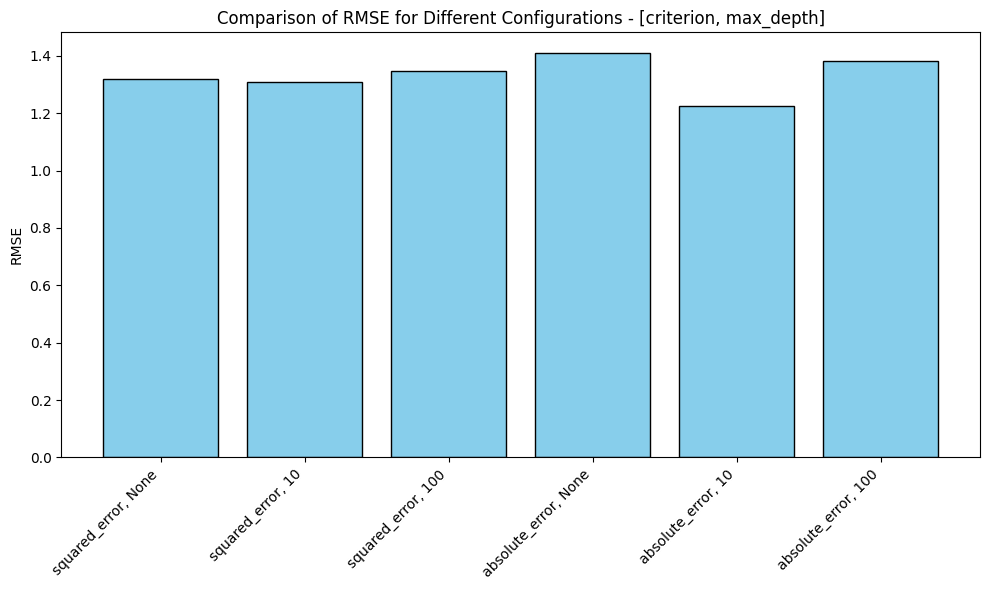

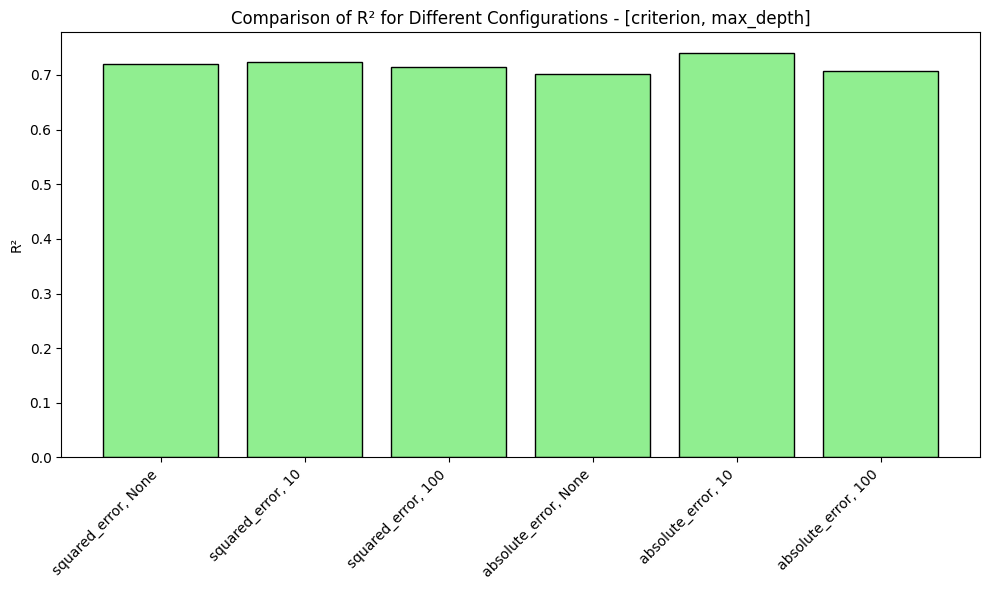

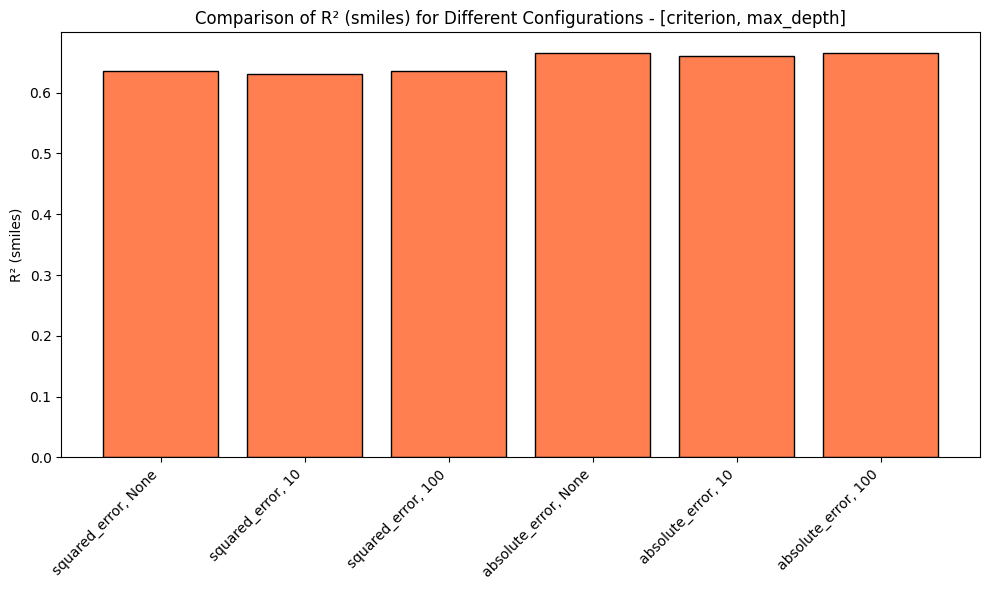

In [32]:
# Data processing
labels = [f"{key[0]}, {key[1]}" for key in results_tree.keys()]
rmse_values = [value['rmse'] for value in results_tree.values()]
r2_values = [value['r2'] for value in results_tree.values()]
r2_smiles_values = [value['r2_smiles'] for value in results_tree.values()]

x = np.arange(len(labels))

# Plot 1: RMSE
plt.figure(figsize=(10, 6))
plt.bar(x, rmse_values, color='skyblue', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Configurations - [criterion, max_depth]')
plt.tight_layout()
plt.show()

# Plot 2: R2
plt.figure(figsize=(10, 6))
plt.bar(x, r2_values, color='lightgreen', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R²')
plt.title('Comparison of R² for Different Configurations - [criterion, max_depth]')
plt.tight_layout()
plt.show()

# Plot 3: R2_smiles
plt.figure(figsize=(10, 6))
plt.bar(x, r2_smiles_values, color='coral', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R² (smiles)')
plt.title('Comparison of R² (smiles) for Different Configurations - [criterion, max_depth]')
plt.tight_layout()
plt.show()

##Section 4.2 - Random Forest Regression

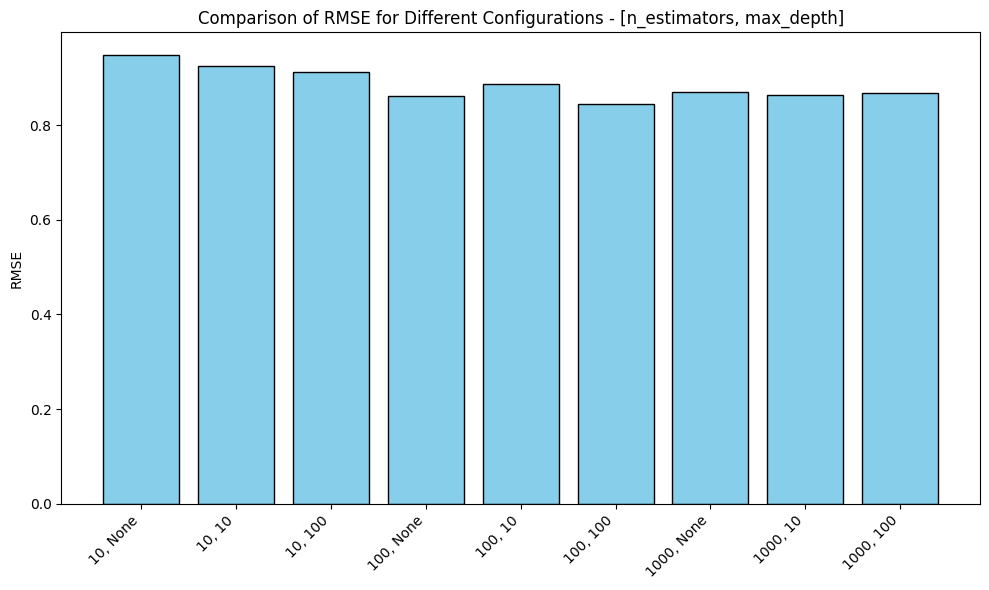

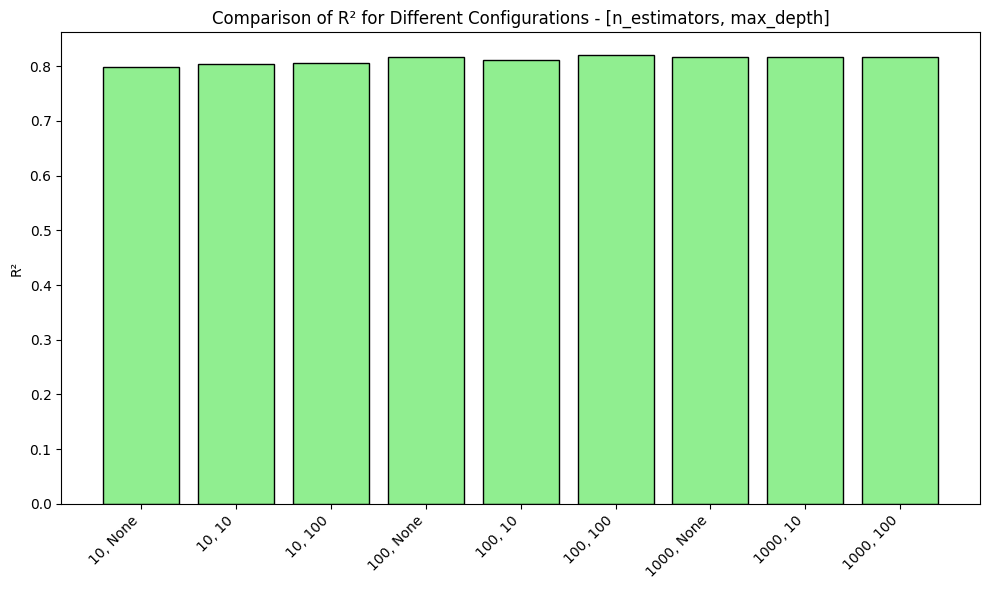

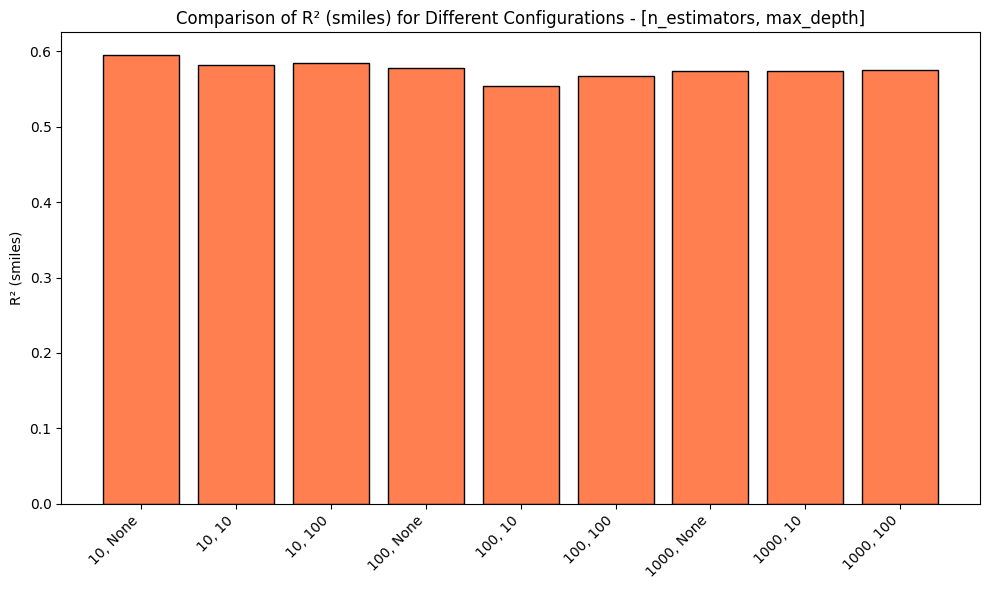

In [33]:
# Data processing
labels = [f"{key[0]}, {key[1]}" for key in results_rf.keys()]
rmse_values = [value['rmse'] for value in results_rf.values()]
r2_values = [value['r2'] for value in results_rf.values()]
r2_smiles_values = [value['r2_smiles'] for value in results_rf.values()]

x = np.arange(len(labels))

# Plot 1: RMSE
plt.figure(figsize=(10, 6))
plt.bar(x, rmse_values, color='skyblue', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Configurations - [n_estimators, max_depth]')
plt.tight_layout()
plt.show()

# Plot 2: R²
plt.figure(figsize=(10, 6))
plt.bar(x, r2_values, color='lightgreen', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R²')
plt.title('Comparison of R² for Different Configurations - [n_estimators, max_depth]')
plt.tight_layout()
plt.show()

# Plot 3: R²_smiles
plt.figure(figsize=(10, 6))
plt.bar(x, r2_smiles_values, color='coral', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R² (smiles)')
plt.title('Comparison of R² (smiles) for Different Configurations - [n_estimators, max_depth]')
plt.tight_layout()
plt.show()

##Section 4.3 - Support Vector Machine

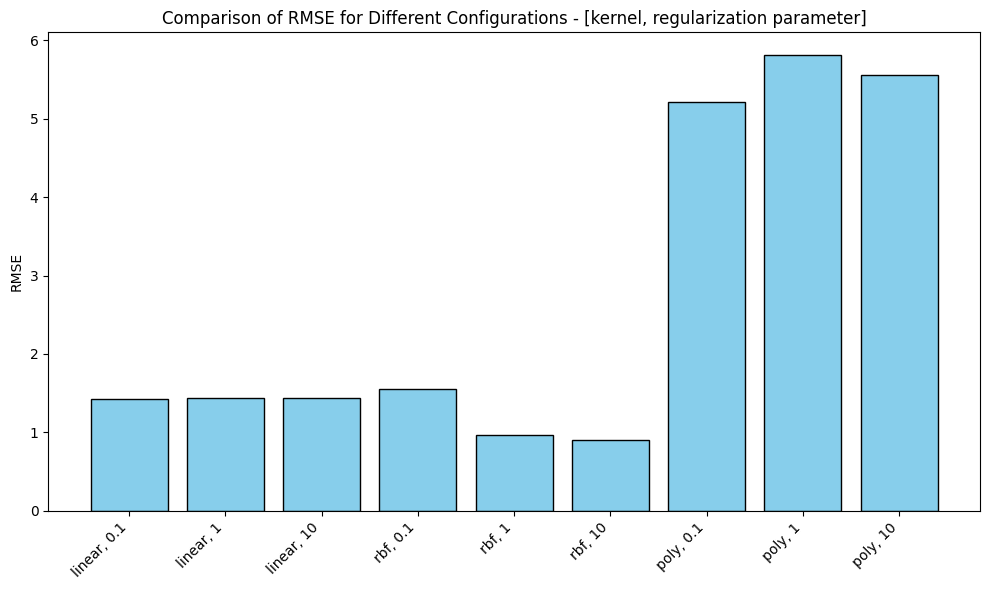

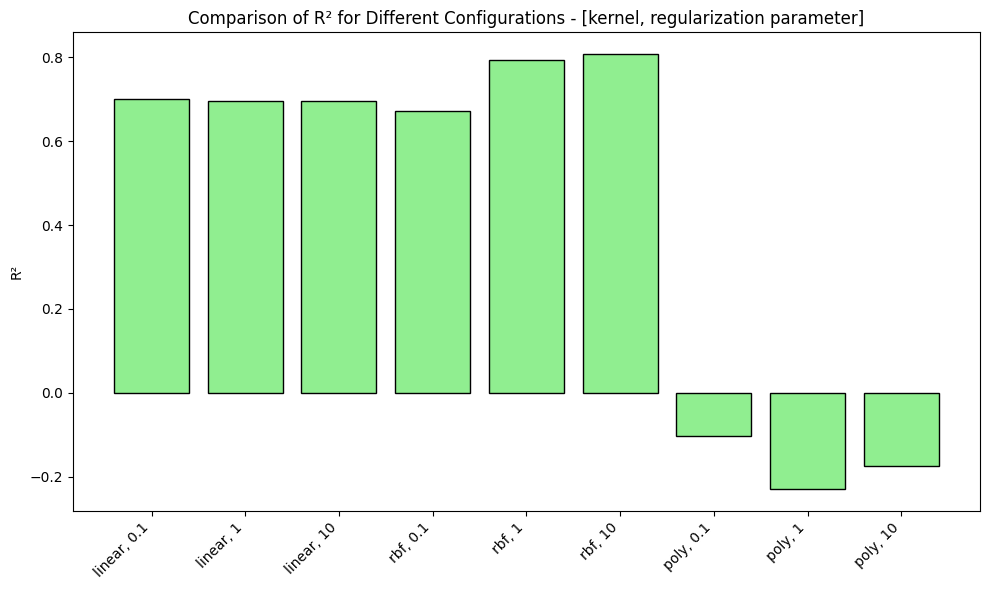

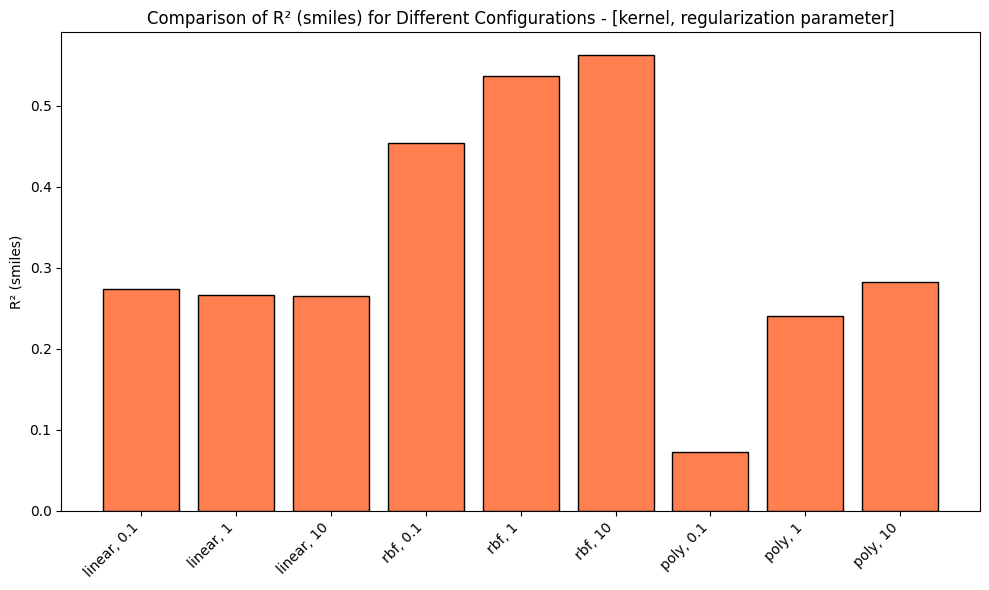

In [34]:
# Data processing
labels = [f"{key[0]}, {key[1]}" for key in results_svr.keys()]
rmse_values = [value['rmse'] for value in results_svr.values()]
r2_values = [value['r2'] for value in results_svr.values()]
r2_smiles_values = [value['r2_smiles'] for value in results_svr.values()]

x = np.arange(len(labels))

# Plot 1: RMSE
plt.figure(figsize=(10, 6))
plt.bar(x, rmse_values, color='skyblue', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Configurations - [kernel, regularization parameter]')
plt.tight_layout()
plt.show()

# Plot 2: R²
plt.figure(figsize=(10, 6))
plt.bar(x, r2_values, color='lightgreen', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R²')
plt.title('Comparison of R² for Different Configurations - [kernel, regularization parameter]')
plt.tight_layout()
plt.show()

# Plot 3: R²_smiles
plt.figure(figsize=(10, 6))
plt.bar(x, r2_smiles_values, color='coral', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R² (smiles)')
plt.title('Comparison of R² (smiles) for Different Configurations - [kernel, regularization parameter]')
plt.tight_layout()
plt.show()

##Section 4.4 - Multi Layer Perceptron

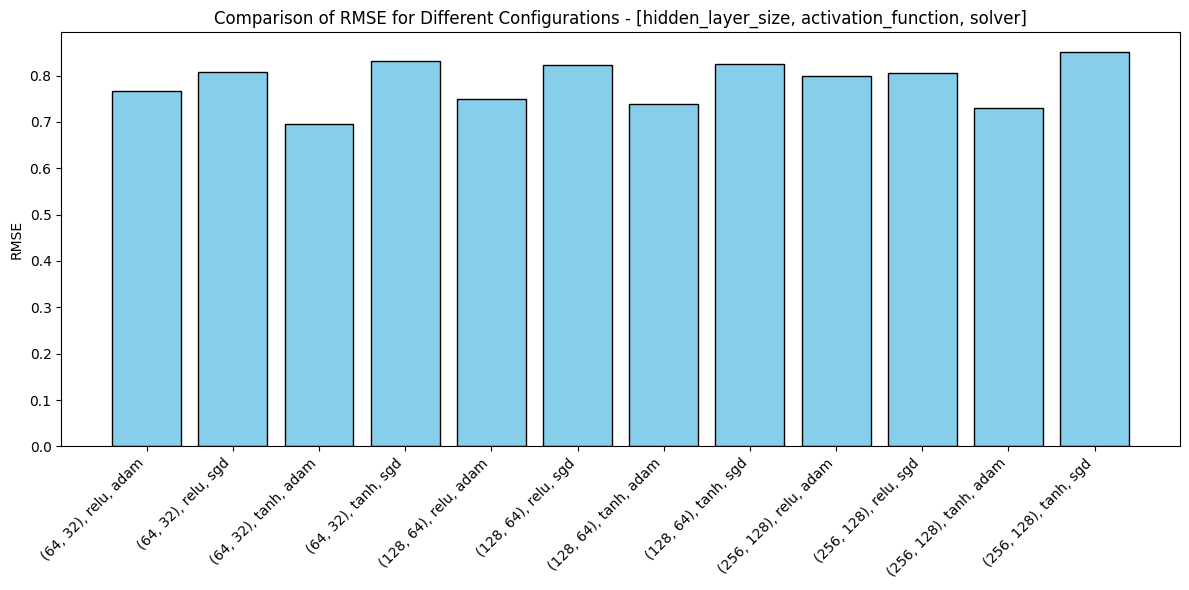

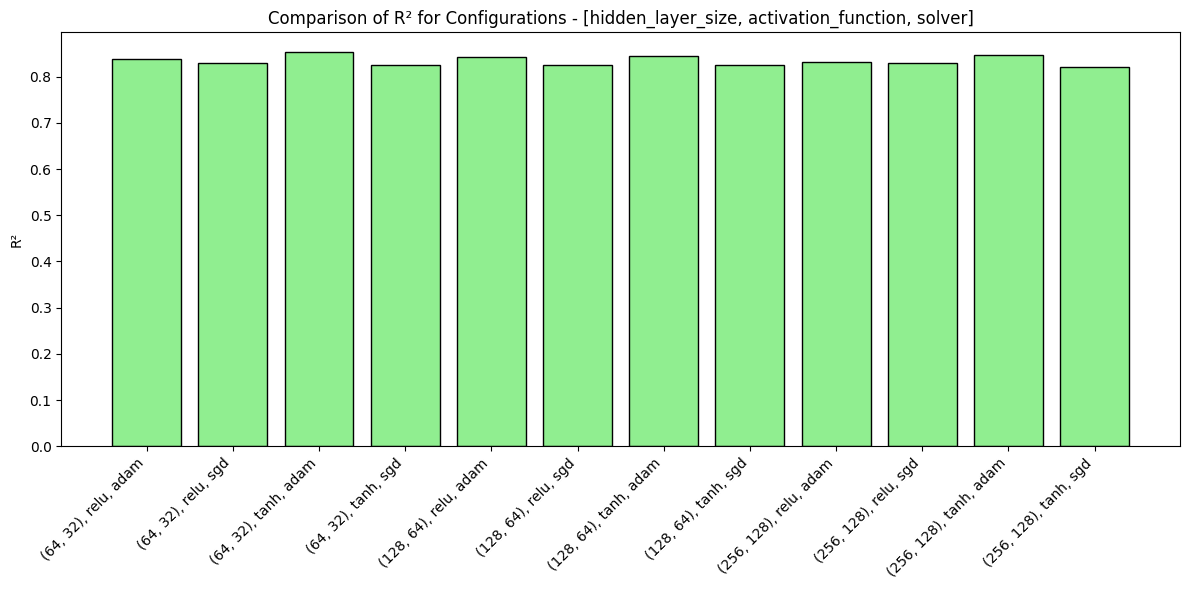

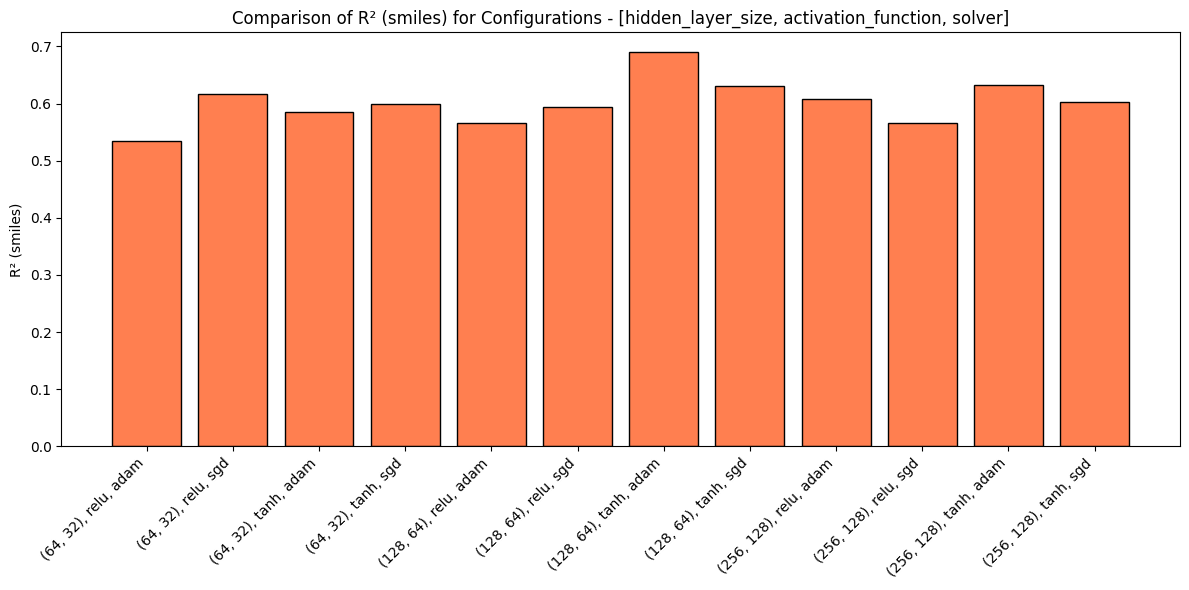

In [35]:
# Data processing to adapt for three hyperparameters
labels = [f"{key[0]}, {key[1]}, {key[2]}" for key in results_mlp.keys()]
rmse_values = [value['rmse'] for value in results_mlp.values()]
r2_values = [value['r2'] for value in results_mlp.values()]
r2_smiles_values = [value['r2_smiles'] for value in results_mlp.values()]

x = np.arange(len(labels))

# Plot 1: RMSE
plt.figure(figsize=(12, 6))
plt.bar(x, rmse_values, color='skyblue', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Configurations - [hidden_layer_size, activation_function, solver]')
plt.tight_layout()
plt.show()

# Plot 2: R²
plt.figure(figsize=(12, 6))
plt.bar(x, r2_values, color='lightgreen', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R²')
plt.title('Comparison of R² for Configurations - [hidden_layer_size, activation_function, solver]')
plt.tight_layout()
plt.show()

# Plot 3: R²_smiles
plt.figure(figsize=(12, 6))
plt.bar(x, r2_smiles_values, color='coral', edgecolor='black')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('R² (smiles)')
plt.title('Comparison of R² (smiles) for Configurations - [hidden_layer_size, activation_function, solver]')
plt.tight_layout()
plt.show()